### Optimizing England Cricket Team Selection and Composition Using Player Performance Analytics



**Project Goal:**

Develop a data-driven approach to explore and select the optimal batting and bowling lineups for the England T20I team, maximizing their chances of success in the 2024 T20 World Cup.

All data has been obtained from the following kaggle page: https://www.kaggle.com/datasets/bhuvaneshprasad/all-t20-internationals-dataset-2005-to-2023?select=t20i_Matches_Data.csv

Caveats:
* Retirement Status: This project does not account for whether players are currently active or retired. The selection is purely based on historical performance data.
* Injury and Availability: Player availability due to injuries or personal reasons has not been considered.
* Current Form: The project does not consider the players' current form or recent performance trends, focusing only on aggregated historical data.
* External Factors: Factors such as pitch conditions, opposition strength, and weather conditions are not accounted for in this analysis.
* Role Specifications: The analysis assumes general roles (batters, bowlers, all-rounders) without going into specific sub-roles like openers, middle-order batters, or types of bowlers (e.g., fast, spin).
* Exploratory Nature: This project is mainly exploratory and intended for academic and illustrative purposes. The results should not be taken as definitive or factual for actual team selection decisions.
* Data Limitations: The analysis is based on the available dataset, which may not include the most recent matches or complete player statistics.
* Simplified Metrics: The metrics used for optimization (e.g., batting average, strike rate, bowling average, economy rate) are simplified and may not capture all nuances of player performance.

#### Import Libraries

In [201]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
from math import pi

#### Data Loading

In [202]:
players_info = pd.read_csv("players_info.csv")
t20i_batting_card = pd.read_csv("t20i_Batting_Card.csv")
t20i_bowling_card = pd.read_csv("t20i_Bowling_Card.csv")
t20i_fow_card = pd.read_csv("t20i_Fow_Card.csv")
t20i_matches_data = pd.read_csv("t20i_Matches_Data.csv")
t20i_partnership_card = pd.read_csv("t20i_Partnership_Card.csv")

In [203]:
players_info.head(1)

,player_id,player_object_id,player_name,dob,dod,gender,batting_style,bowling_style,country_id,image_url,image_metadata
0,93957,1046619,Avinash Pai,1982-01-24,NaN,M,right-hand bat,right-arm offbreak,18.0,NaN,NaN


In [204]:
t20i_batting_card.head(1)

,Match ID,innings,team,batsman,runs,balls,fours,sixes,strikeRate,isOut,wicketType,fielders,bowler
0,361657,1,Zimbabwe,10423.0,53.0,38.0,5.0,3.0,139.47,True,run out,['47099'],NaN


In [205]:
t20i_bowling_card.head(1)

,Match ID,innings,team,opposition,bowler id,overs,balls,maidens,conceded,wickets,economy,dots,fours,sixes,wides,noballs
0,300436,1,New Zealand,England,10303.0,4.0,24.0,0.0,35.0,1.0,8.75,10.0,3.0,2.0,1.0,0.0


In [206]:
t20i_fow_card.head(1)

,Match ID,innings,team,player,wicket,over,runs
0,291356,1,India,7781.0,1.0,0.5,5.0


In [207]:
t20i_matches_data.head(1)

,T20I Match No,Match ID,Match Name,Series ID,Series Name,Match Date,Match Format,Team1 ID,Team1 Name,Team1 Captain,...,Umpire 2,Match Referee,Toss Winner,Toss Winner Choice,Match Winner,Match Result Text,MOM Player,Team1 Playing 11,Team2 Playing 11,Debut Players
0,52,291356,Australia Vs India Only T20I,291355,India tour of Australia - 2007 (2007/08),2008-02-01,T20,6,India,7593,...,SJA Taufel,JJ Crowe,India,bat,Australia,Australia won by 9 wickets (with 52 balls rema...,8876.0,"['7773', '7781', '8813', '8742', '48405', '759...","['4176', '8876', '6253', '6256', '4382', '1198...","['11984', '49327', '48319']"


In [208]:
t20i_partnership_card.head(1)

,Match ID,innings,for wicket,team,opposition,player1,player2,player1 runs,player2 runs,player1 balls,player2 balls,partnership runs,partnership balls
0,361660,1,1.0,Pakistan,Sri Lanka,11647.0,47738.0,0.0,0.0,0.0,5.0,9.0,10.0


#### EDA

* Match Strategy: Gain insights into the impact of toss decisions on match outcomes.
* Performance Evaluation: Evaluate player and team performances based on batting and bowling statistics.

In [209]:
# Add the country names to the players_info table to allow filtering
players_info = players_info.merge(t20i_matches_data[['Team1 ID', 'Team1 Name']], left_on='country_id', right_on='Team1 ID')

In [210]:
# Filter for England players
players_info = players_info[players_info['Team1 Name'] == 'England']

In [211]:
# Get the age of each player

#  Get today's date
today = date.today()

# Convert 'dob' column to datetime
players_info['dob'] = pd.to_datetime(players_info['dob'])

# Calculate age, handling NaN values
players_info['age'] = (today - players_info['dob'].dt.date).apply(lambda x: x.days // 365.2425 if not np.isnan(x.days) else np.nan)

# Label all-rounder players (i.e. players who can bat and bowl)
players_info['is_all_rounder'] = players_info['bowling_style'].notnull() & players_info['batting_style'].notnull()


In [212]:
# match strategy: england toss wins impact on winning the match

# Step 1: Filter matches involving England
england_matches = t20i_matches_data[(t20i_matches_data['Team1 Name'] == 'England') | (t20i_matches_data['Team2 Name'] == 'England')]

# Step 2: Calculate the total number of matches England has played in
total_england_matches = england_matches.shape[0]

# Step 3: Count how many times England has won the toss in those matches
england_toss_wins = england_matches[england_matches['Toss Winner'] == 'England'].shape[0]

# Step 4: Count how many of those matches where England won the toss they also won the match
england_toss_and_match_wins = england_matches[(england_matches['Toss Winner'] == 'England') & (england_matches['Match Winner'] == 'England')].shape[0]

# Step 5: Calculate the proportions
proportion_matches_england_played = total_england_matches / t20i_matches_data.shape[0]
proportion_tosses_won_by_england = england_toss_wins / total_england_matches
match_win_rate_after_winning_toss = england_toss_and_match_wins / england_toss_wins

proportion_matches_england_played, proportion_tosses_won_by_england, match_win_rate_after_winning_toss

(0.07021604938271606, 0.489010989010989, 0.48314606741573035)

For the England team in T20i's, toss wins don't seem to have a substantial impact on the probability of winning a match based on the above statistics. It could be interesting to explore how this varies between different types of games (one-day and test matches), and also how it varies by pitch conditions (damp? dry?) which may weigh more heavily on the post-toss win decision.

In [213]:
## Create a dataframe which aggregates batting performance per batsman, to allow analysis of batting performance across matches

# Group by 'batsman' column
grouped = t20i_batting_card.groupby('batsman')

# Calculate statistical aggregates
batting_performance = grouped.agg({
    'runs': ['sum', 'mean', 'min', 'max', 'std'],
    'balls': ['sum', 'mean', 'min', 'max', 'std'],
    'fours': ['sum', 'mean', 'min', 'max', 'std'],
    'sixes': ['sum', 'mean', 'min', 'max', 'std'],
    'strikeRate': ['sum', 'mean', 'min', 'max', 'std'],
    'Match ID': 'nunique',  # Count of unique matches
    'team': lambda x: list(x.unique())  # Unique teams
})

# Rename the columns
batting_performance.columns = ['_'.join(col).strip() for col in batting_performance.columns.values]
batting_performance.reset_index(inplace=True)

# Rename the match_id column to matches_played
batting_performance.rename(columns={'Match ID_nunique': 'matches_played'}, inplace=True)

# Create additional performance assessment variables
# Calculating additional metrics: boundary percentage and dot ball percentage
batting_performance['boundary_percentage'] = (
    (batting_performance['fours_mean'] * 4 + batting_performance['sixes_mean'] * 6)
    / batting_performance['runs_mean'] * 100
).fillna(0)  # Fill NaN values with 0

batting_performance['dot_ball_percentage'] = (
    ((batting_performance['balls_mean'] - (batting_performance['fours_mean'] + batting_performance['sixes_mean'])) 
    / batting_performance['balls_mean']) * 100
).fillna(0)  # Fill NaN values with 0

# Handling multiple teams (i.e. some players may have played for other teams before England)
# Expand the teams column into separate columns
max_teams = batting_performance['team_<lambda>'].apply(len).max()
for i in range(max_teams):
    batting_performance[f'team_{i+1}'] = batting_performance['team_<lambda>'].apply(lambda x: x[i] if i < len(x) else np.nan)

# Drop the original teams list column
batting_performance.drop(columns=['team_<lambda>'], inplace=True)

# Show the first few rows of the resulting DataFrame
batting_performance.head()

,batsman,runs_sum,runs_mean,runs_min,runs_max,runs_std,balls_sum,balls_mean,balls_min,balls_max,...,strikeRate_mean,strikeRate_min,strikeRate_max,strikeRate_std,Match ID_nunique,boundary_percentage,dot_ball_percentage,team_1,team_2,team_3
0,1934.0,10.0,10.000000,10.0,10.0,NaN,12.0,12.000000,12.0,12.0,...,83.330,83.33,83.33,NaN,1,80.000000,83.333333,India,NaN,NaN
1,1939.0,3.0,1.500000,1.0,2.0,0.707107,13.0,6.500000,4.0,9.0,...,23.610,22.22,25.00,1.965757,2,0.000000,100.000000,New Zealand,NaN,NaN
2,1979.0,5.0,5.000000,5.0,5.0,NaN,8.0,8.000000,8.0,8.0,...,62.500,62.50,62.50,NaN,2,0.000000,100.000000,Sri Lanka,NaN,NaN
3,1988.0,629.0,20.966667,0.0,88.0,24.010750,487.0,16.233333,0.0,47.0,...,96.322,0.00,221.73,67.884016,31,70.270270,79.671458,Sri Lanka,NaN,NaN
4,2034.0,11.0,11.000000,11.0,11.0,NaN,15.0,15.000000,15.0,15.0,...,73.330,73.33,73.33,NaN,1,54.545455,93.333333,Pakistan,NaN,NaN


In [214]:
players_info.head(1)

,player_id,player_object_id,player_name,dob,dod,gender,batting_style,bowling_style,country_id,image_url,image_metadata,Team1 ID,Team1 Name,age,is_all_rounder
269,52290,298438,Jason Roy,1990-07-21,NaN,M,right-hand bat,NaN,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...","{'id': 303963, 'url': '/db/PICTURES/CMS/303900...",1,England,33.0,False


In [215]:
# convert batsman ID column to integer so it is the same data type as player_id in players_info table, allowing the join
batting_performance['batsman'] = batting_performance['batsman'].astype('int64')

players_info = players_info.merge(batting_performance, left_on='player_id', right_on='batsman', how='left')

In [216]:
players_info.drop_duplicates(subset=['player_id'], keep='first', inplace=True)


In [217]:
players_info.head()

,player_id,player_object_id,player_name,dob,dod,gender,batting_style,bowling_style,country_id,image_url,...,strikeRate_mean,strikeRate_min,strikeRate_max,strikeRate_std,Match ID_nunique,boundary_percentage,dot_ball_percentage,team_1,team_2,team_3
0,52290,298438,Jason Roy,1990-07-21,NaN,M,right-hand bat,NaN,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,119.675938,0.0,268.75,62.668324,64.0,67.411301,79.927667,England,NaN,NaN
82,52161,297433,Jonny Bairstow,1989-09-26,NaN,M,right-hand bat,right-arm medium,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,120.672656,0.0,261.11,63.993084,70.0,62.301587,81.619654,England,NaN,NaN
164,52656,303669,Joe Root,1990-12-30,NaN,M,right-hand bat,right-arm offbreak,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,109.467333,0.0,200.00,48.856733,32.0,51.959686,84.724187,England,NaN,NaN
246,47055,24598,Eoin Morgan,1986-09-10,NaN,M,left-hand bat,right-arm medium,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,120.356449,0.0,259.09,57.054059,115.0,59.560618,83.047091,England,NaN,NaN
328,105,18007,Billy Newham,1860-12-12,1944-06-26,M,right-hand bat,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
for col in players_info.columns:
    print(col)

player_id
player_object_id
player_name
dob
dod
gender
batting_style
bowling_style
country_id
image_url
image_metadata
Team1 ID
Team1 Name
age
is_all_rounder
batsman
runs_sum
runs_mean
runs_min
runs_max
runs_std
balls_sum
balls_mean
balls_min
balls_max
balls_std
fours_sum
fours_mean
fours_min
fours_max
fours_std
sixes_sum
sixes_mean
sixes_min
sixes_max
sixes_std
strikeRate_sum
strikeRate_mean
strikeRate_min
strikeRate_max
strikeRate_std
Match ID_nunique
boundary_percentage
dot_ball_percentage
team_1
team_2
team_3


In [219]:
# what are the age ranges we have in our dataset
england_players['age'].unique()

array([33., 34., 37., 36., 35., 39., 29., 27., 30., 38., 28., 25., 26.,
       31., 32., 19., 23.])

With more time, it would be interesting to explore the batting/bowling statisics of players by age - does age affect performance? should we have a wide range of players in the final team or a narrow one? this would need taking into account level of experience in cricket, deterioration in performance, etc.

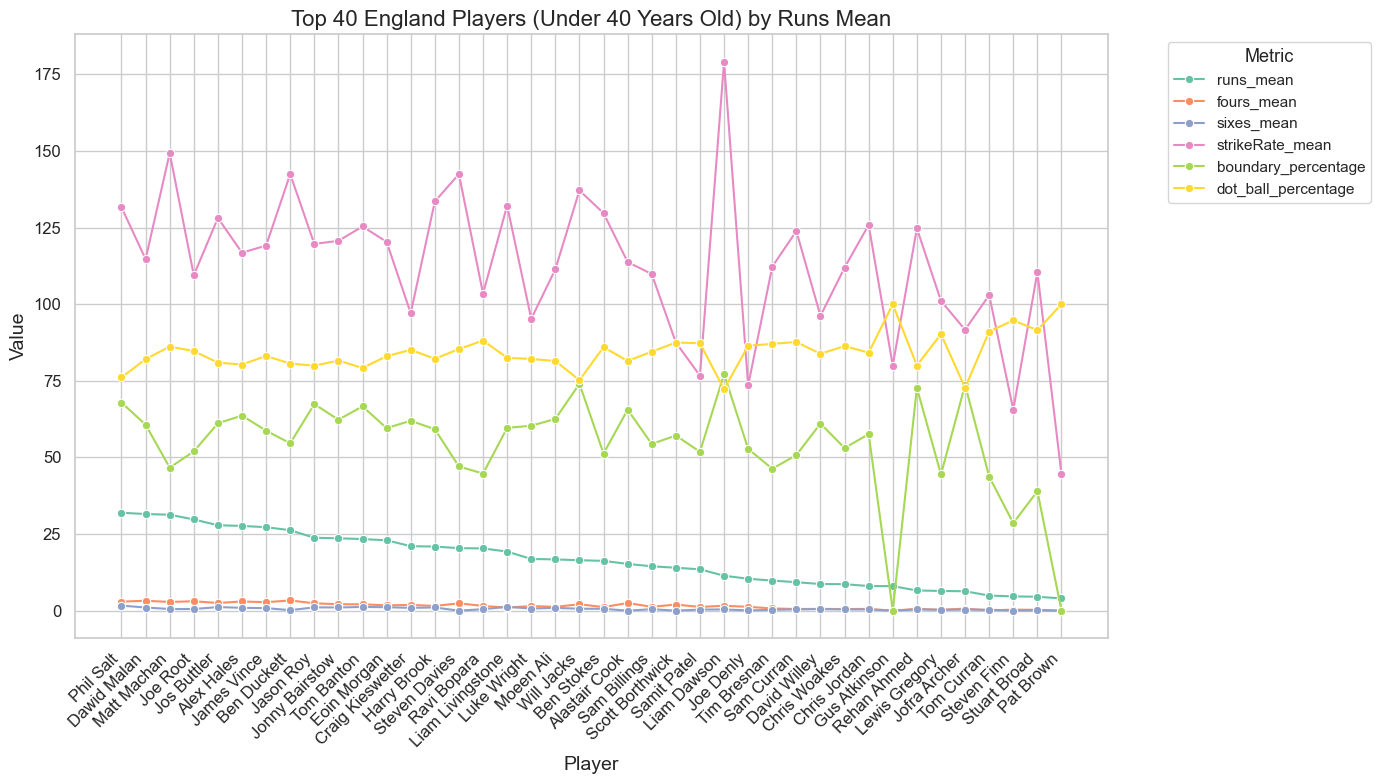

In [220]:
# Filter for England players who are under the age of 40
england_players = players_info[(players_info['Team1 Name'].str.contains('England')) & (players_info['age'] < 40)]

# Sort players by runs_mean in descending order
england_players_sorted = england_players.sort_values(by='runs_mean', ascending=False)

# Take top 40 players
top_40_players = england_players_sorted.head(40)

# Prepare the data for plotting
plot_data = top_40_players.melt(id_vars=['player_id', 'player_name'], 
                                value_vars=['runs_mean', 'fours_mean', 'sixes_mean', 'strikeRate_mean', 'boundary_percentage', 'dot_ball_percentage'], 
                                var_name='metric', 
                                value_name='value')

# Create the plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plot each metric
sns.lineplot(data=plot_data, x='player_name', y='value', hue='metric', marker='o', palette='Set2')

# Enhance the plot
plt.title('Top 40 England Players (Under 40 Years Old) by Runs Mean', fontsize=16)
plt.xlabel('Player', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Metric', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [221]:
t20i_bowling_card.head(1)

,Match ID,innings,team,opposition,bowler id,overs,balls,maidens,conceded,wickets,economy,dots,fours,sixes,wides,noballs
0,300436,1,New Zealand,England,10303.0,4.0,24.0,0.0,35.0,1.0,8.75,10.0,3.0,2.0,1.0,0.0


In [222]:
## Create a dataframe which aggregates bowling performance per bowler, to allow analysis of bowling performance across matches

# Group by 'bowler id' column
grouped = t20i_bowling_card.groupby('bowler id')

# Calculate statistical aggregates
bowling_performance = grouped.agg({
    'overs': ['sum', 'mean', 'min', 'max', 'std'],
    'balls': ['sum', 'mean', 'min', 'max', 'std'],
    'maidens': ['sum', 'mean', 'min', 'max', 'std'],
    'conceded': ['sum', 'mean', 'min', 'max', 'std'],
    'wickets': ['sum', 'mean', 'min', 'max', 'std'],
    'economy': ['sum', 'mean', 'min', 'max', 'std'],
    'dots': ['sum', 'mean', 'min', 'max', 'std'],
    'fours': ['sum', 'mean', 'min', 'max', 'std'],
    'sixes': ['sum', 'mean', 'min', 'max', 'std'],
    'wides': ['sum', 'mean', 'min', 'max', 'std'],
    'noballs': ['sum', 'mean', 'min', 'max', 'std'],
    'Match ID': 'nunique',  # Count of unique matches
    'team': lambda x: list(x.unique())  # Unique teams
})

# Rename the columns
bowling_performance.columns = ['_'.join(col).strip() for col in bowling_performance.columns.values]
bowling_performance.reset_index(inplace=True)

# Rename the match_id column to matches_played
bowling_performance.rename(columns={'match_id_nunique': 'matches_played'}, inplace=True)

# Show the first few rows of the resulting DataFrame
bowling_performance.head()

,bowler id,overs_sum,overs_mean,overs_min,overs_max,overs_std,balls_sum,balls_mean,balls_min,balls_max,...,wides_min,wides_max,wides_std,noballs_sum,noballs_mean,noballs_min,noballs_max,noballs_std,Match ID_nunique,team_<lambda>
0,1934.0,2.3,2.300000,2.3,2.3,NaN,15.0,15.000000,15.0,15.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1,[India]
1,1939.0,8.0,4.000000,4.0,4.0,0.000000,48.0,24.000000,24.0,24.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2,[New Zealand]
2,1988.0,61.5,2.562500,1.0,4.0,1.262438,371.0,15.458333,6.0,24.0,...,0.0,1.0,0.464306,0.0,0.0,0.0,0.0,0.0,24,[Sri Lanka]
3,2041.0,47.0,3.916667,3.0,4.0,0.288675,282.0,23.500000,18.0,24.0,...,0.0,3.0,1.029857,0.0,0.0,0.0,0.0,0.0,12,[Sri Lanka]
4,2101.0,8.0,4.000000,4.0,4.0,0.000000,48.0,24.000000,24.0,24.0,...,0.0,1.0,0.707107,0.0,0.0,0.0,0.0,0.0,2,[Australia]


In [223]:
bowling_performance['bowler id'] = bowling_performance['bowler id'].astype('int64')

players_info = players_info.merge(bowling_performance, left_on='player_id', right_on='bowler id', how='left')

In [224]:
players_info

,player_id,player_object_id,player_name,dob,dod,gender,batting_style,bowling_style,country_id,image_url,...,wides_min,wides_max,wides_std,noballs_sum,noballs_mean,noballs_min,noballs_max,noballs_std,Match ID_nunique_y,team_<lambda>
0,52290,298438,Jason Roy,1990-07-21,NaN,M,right-hand bat,NaN,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52161,297433,Jonny Bairstow,1989-09-26,NaN,M,right-hand bat,right-arm medium,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52656,303669,Joe Root,1990-12-30,NaN,M,right-hand bat,right-arm offbreak,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,0.0,2.0,0.707107,0.0,0.0,0.0,0.0,0.0,9.0,[England]
3,47055,24598,Eoin Morgan,1986-09-10,NaN,M,left-hand bat,right-arm medium,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,18007,Billy Newham,1860-12-12,1944-06-26,M,right-hand bat,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,4196,8499,Usman Afzaal,1977-06-09,NaN,M,left-hand bat,slow left-arm orthodox,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,709,18619,Fred Price,1902-04-25,1969-01-13,M,right-hand bat,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,4327,14149,Warren Hegg,1968-02-23,NaN,M,right-hand bat,NaN,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748,1905,10721,John Childs,1951-08-15,NaN,M,left-hand bat,NaN,1.0,"https://img1.hscicdn.com/image/upload/f_auto,t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


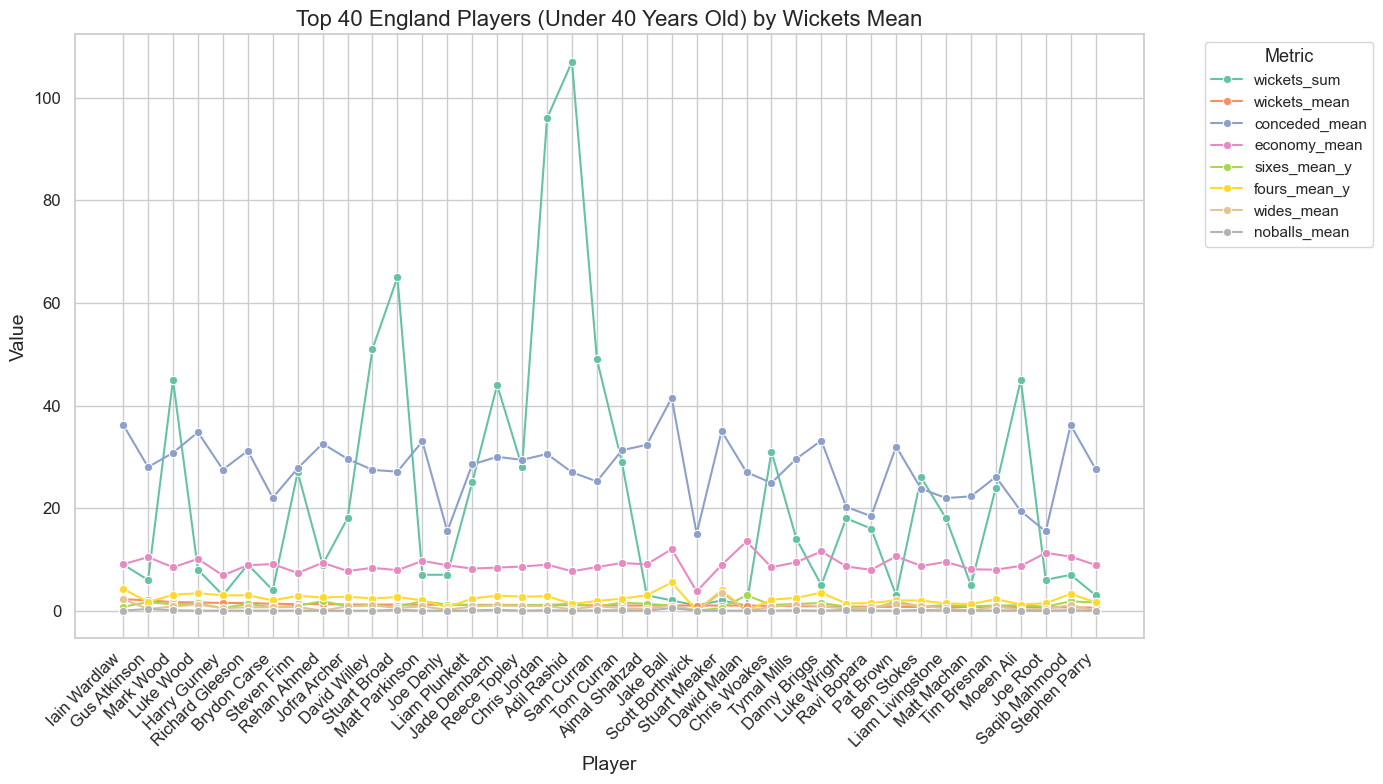

In [226]:
# Filter for England players who are under the age of 40
england_players = players_info[(players_info['Team1 Name'].str.contains('England')) & (players_info['age'] < 40)]

# Sort players by runs_mean in descending order
england_players_sorted = england_players.sort_values(by='wickets_mean', ascending=False)

# Take top 40 players
top_40_players = england_players_sorted.head(40)

# Prepare the data for plotting
plot_data = top_40_players.melt(id_vars=['player_id', 'player_name'], 
                                value_vars=['wickets_sum', 'wickets_mean', 'conceded_mean', 'economy_mean', 'sixes_mean_y', 'fours_mean_y', 'wides_mean', 'noballs_mean'], 
                                var_name='metric', 
                                value_name='value')

# Create the plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plot each metric
sns.lineplot(data=plot_data, x='player_name', y='value', hue='metric', marker='o', palette='Set2')

# Enhance the plot
plt.title('Top 40 England Players (Under 40 Years Old) by Wickets Mean', fontsize=16)
plt.xlabel('Player', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Metric', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [227]:
# Columns to rename with "bowlingstats_" prefix
columns_to_rename = {
    'overs_sum': 'bowlingstats_overs_sum',
    'overs_mean': 'bowlingstats_overs_mean',
    'overs_min': 'bowlingstats_overs_min',
    'overs_max': 'bowlingstats_overs_max',
    'overs_std': 'bowlingstats_overs_std',
    'balls_sum_y': 'bowlingstats_balls_sum',
    'balls_mean_y': 'bowlingstats_balls_mean',
    'balls_min_y': 'bowlingstats_balls_min',
    'balls_max_y': 'bowlingstats_balls_max',
    'balls_std_y': 'bowlingstats_balls_std',
    'maidens_sum': 'bowlingstats_maidens_sum',
    'maidens_mean': 'bowlingstats_maidens_mean',
    'maidens_min': 'bowlingstats_maidens_min',
    'maidens_max': 'bowlingstats_maidens_max',
    'maidens_std': 'bowlingstats_maidens_std',
    'conceded_sum': 'bowlingstats_conceded_sum',
    'conceded_mean': 'bowlingstats_conceded_mean',
    'conceded_min': 'bowlingstats_conceded_min',
    'conceded_max': 'bowlingstats_conceded_max',
    'conceded_std': 'bowlingstats_conceded_std',
    'wickets_sum': 'bowlingstats_wickets_sum',
    'wickets_mean': 'bowlingstats_wickets_mean',
    'wickets_min': 'bowlingstats_wickets_min',
    'wickets_max': 'bowlingstats_wickets_max',
    'wickets_std': 'bowlingstats_wickets_std',
    'economy_sum': 'bowlingstats_economy_sum',
    'economy_mean': 'bowlingstats_economy_mean',
    'economy_min': 'bowlingstats_economy_min',
    'economy_max': 'bowlingstats_economy_max',
    'economy_std': 'bowlingstats_economy_std',
    'dots_sum': 'bowlingstats_dots_sum',
    'dots_mean': 'bowlingstats_dots_mean',
    'dots_min': 'bowlingstats_dots_min',
    'dots_max': 'bowlingstats_dots_max',
    'dots_std': 'bowlingstats_dots_std',
    'fours_sum_y': 'bowlingstats_fours_sum',
    'fours_mean_y': 'bowlingstats_fours_mean',
    'fours_min_y': 'bowlingstats_fours_min',
    'fours_max_y': 'bowlingstats_fours_max',
    'fours_std_y': 'bowlingstats_fours_std',
    'sixes_sum_y': 'bowlingstats_sixes_sum',
    'sixes_mean_y': 'bowlingstats_sixes_mean',
    'sixes_min_y': 'bowlingstats_sixes_min',
    'sixes_max_y': 'bowlingstats_sixes_max',
    'sixes_std_y': 'bowlingstats_sixes_std',
    'wides_sum': 'bowlingstats_wides_sum',
    'wides_mean': 'bowlingstats_wides_mean',
    'wides_min': 'bowlingstats_wides_min',
    'wides_max': 'bowlingstats_wides_max',
    'wides_std': 'bowlingstats_wides_std',
    'noballs_sum': 'bowlingstats_noballs_sum',
    'noballs_mean': 'bowlingstats_noballs_mean',
    'noballs_min': 'bowlingstats_noballs_min',
    'noballs_max': 'bowlingstats_noballs_max',
    'noballs_std': 'bowlingstats_noballs_std',
    'Match ID_nunique_y': 'bowlingstats_match_id_nunique',
    'team_<lambda>': 'bowlingstats_team'
}

# Rename the columns in players_info DataFrame
players_info.rename(columns=columns_to_rename, inplace=True)

# Now players_info DataFrame has columns prefixed with "bowlingstats_"
print(players_info.columns)

Index(['player_id', 'player_object_id', 'player_name', 'dob', 'dod', 'gender',
       'batting_style', 'bowling_style', 'country_id', 'image_url',
       ...
       'bowlingstats_wides_min', 'bowlingstats_wides_max',
       'bowlingstats_wides_std', 'bowlingstats_noballs_sum',
       'bowlingstats_noballs_mean', 'bowlingstats_noballs_min',
       'bowlingstats_noballs_max', 'bowlingstats_noballs_std',
       'bowlingstats_match_id_nunique', 'bowlingstats_team'],
      dtype='object', length=105)


In [228]:
# Columns to rename with "battingstats_" prefix
columns_to_rename = {
    'runs_sum': 'battingstats_runs_sum',
    'runs_mean': 'battingstats_runs_mean',
    'runs_min': 'battingstats_runs_min',
    'runs_max': 'battingstats_runs_max',
    'runs_std': 'battingstats_runs_std',
    'balls_sum_x': 'battingstats_balls_sum',
    'balls_mean_x': 'battingstats_balls_mean',
    'balls_min_x': 'battingstats_balls_min',
    'balls_max_x': 'battingstats_balls_max',
    'balls_std_x': 'battingstats_balls_std',
    'fours_sum_x': 'battingstats_fours_sum',
    'fours_mean_x': 'battingstats_fours_mean',
    'fours_min_x': 'battingstats_fours_min',
    'fours_max_x': 'battingstats_fours_max',
    'fours_std_x': 'battingstats_fours_std',
    'sixes_sum_x': 'battingstats_sixes_sum',
    'sixes_mean_x': 'battingstats_sixes_mean',
    'sixes_min_x': 'battingstats_sixes_min',
    'sixes_max_x': 'battingstats_sixes_max',
    'sixes_std_x': 'battingstats_sixes_std',
    'strikeRate_sum': 'battingstats_strikeRate_sum',
    'strikeRate_mean': 'battingstats_strikeRate_mean',
    'strikeRate_min': 'battingstats_strikeRate_min',
    'strikeRate_max': 'battingstats_strikeRate_max',
    'strikeRate_std': 'battingstats_strikeRate_std',
    'Match ID_nunique_x': 'battingstats_match_id_nunique',
    'boundary_percentage': 'battingstats_boundary_percentage',
    'dot_ball_percentage': 'battingstats_dot_ball_percentage'
}

# Rename the columns in players_info DataFrame
players_info.rename(columns=columns_to_rename, inplace=True)

# Now players_info DataFrame has columns prefixed with "battingstats_"
print(players_info.columns)

Index(['player_id', 'player_object_id', 'player_name', 'dob', 'dod', 'gender',
       'batting_style', 'bowling_style', 'country_id', 'image_url',
       ...
       'bowlingstats_wides_min', 'bowlingstats_wides_max',
       'bowlingstats_wides_std', 'bowlingstats_noballs_sum',
       'bowlingstats_noballs_mean', 'bowlingstats_noballs_min',
       'bowlingstats_noballs_max', 'bowlingstats_noballs_std',
       'bowlingstats_match_id_nunique', 'bowlingstats_team'],
      dtype='object', length=105)


#### K-means Clustering

In [229]:
missing_values = features.isna().sum()
print(missing_values)

battingstats_runs_mean          35
battingstats_strikeRate_mean    35
bowlingstats_wickets_mean       45
bowlingstats_economy_mean       45
dtype: int64


In [230]:
features.shape

(91, 4)

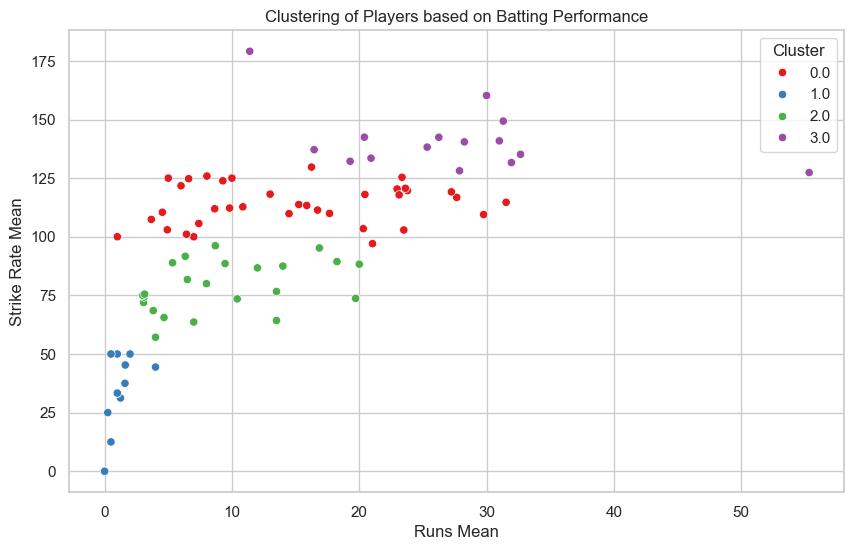

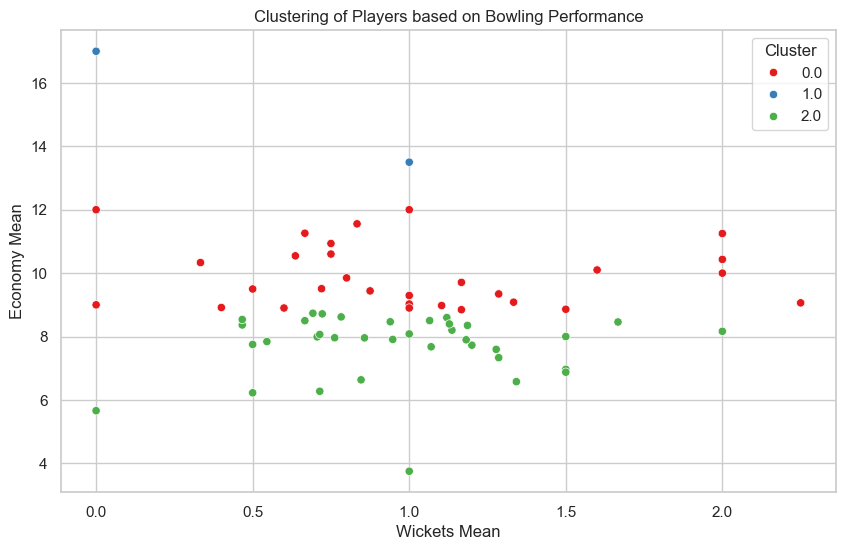

In [231]:


# Assuming players_info DataFrame is ready with relevant features
# Sample data setup (replace this with your actual DataFrame)
# players_info = pd.read_csv('players_info.csv')

# Define columns for batting and bowling statistics
batting_columns = ['battingstats_runs_mean', 'battingstats_strikeRate_mean', 
                   'battingstats_fours_mean', 'battingstats_sixes_mean']

bowling_columns = ['bowlingstats_wickets_mean', 'bowlingstats_economy_mean']

# Split features into batting and bowling
batting_features = players_info[batting_columns]
bowling_features = players_info[bowling_columns]

# Drop rows where either batting or bowling features are null
batting_features = batting_features.dropna()
bowling_features = bowling_features.dropna()

# Handle missing values (if any) in the features
imputer = SimpleImputer(strategy='mean')
batting_features_imputed = pd.DataFrame(imputer.fit_transform(batting_features), columns=batting_features.columns)
bowling_features_imputed = pd.DataFrame(imputer.fit_transform(bowling_features), columns=bowling_features.columns)

# Reset index to ensure alignment if rows were dropped
batting_features_imputed.reset_index(drop=True, inplace=True)
bowling_features_imputed.reset_index(drop=True, inplace=True)

# Apply K-means clustering on batting features
kmeans_batting = KMeans(n_clusters=4, random_state=0)
batting_clusters = kmeans_batting.fit_predict(batting_features_imputed)

# Assign cluster labels back to players_info
players_info.loc[batting_features.index, 'batting_cluster'] = batting_clusters

# Apply K-means clustering on bowling features
kmeans_bowling = KMeans(n_clusters=3, random_state=0)
bowling_clusters = kmeans_bowling.fit_predict(bowling_features_imputed)

# Assign cluster labels back to players_info
players_info.loc[bowling_features.index, 'bowling_cluster'] = bowling_clusters

# Visualize clusters for batting performance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='battingstats_runs_mean', y='battingstats_strikeRate_mean', hue='batting_cluster', data=players_info, palette='Set1', legend='full')
plt.title('Clustering of Players based on Batting Performance')
plt.xlabel('Runs Mean')
plt.ylabel('Strike Rate Mean')
plt.legend(title='Cluster')
plt.show()

# Visualize clusters for bowling performance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bowlingstats_wickets_mean', y='bowlingstats_economy_mean', hue='bowling_cluster', data=players_info, palette='Set1', legend='full')
plt.title('Clustering of Players based on Bowling Performance')
plt.xlabel('Wickets Mean')
plt.ylabel('Economy Mean')
plt.legend(title='Cluster')
plt.show()


In [232]:
# For batting clusters
batting_centroids = kmeans_batting.cluster_centers_
print("Batting Cluster Centroids:\n", batting_centroids)

# For bowling clusters
bowling_centroids = kmeans_bowling.cluster_centers_
print("Bowling Cluster Centroids:\n", bowling_centroids)


Batting Cluster Centroids:
 [[1.49113642e+01 1.13957270e+02 1.35720464e+00 4.87283410e-01]
 [9.81666667e-01 2.75108333e+01 2.50000000e-02 1.33333333e-02]
 [9.31984537e+00 7.88716420e+01 8.36006445e-01 1.40041782e-01]
 [2.72284059e+01 1.41221974e+02 2.80461168e+00 8.10462500e-01]]
Bowling Cluster Centroids:
 [[ 1.00932849  9.9046148 ]
 [ 0.5        15.25      ]
 [ 0.9719146   7.70442504]]


In [233]:
# Summary statistics for batting clusters
batting_cluster_summary = players_info.groupby('batting_cluster')[batting_columns].mean()
print("Batting Cluster Summary:\n", batting_cluster_summary)

# Summary statistics for bowling clusters
bowling_cluster_summary = players_info.groupby('bowling_cluster')[bowling_columns].mean()
print("Bowling Cluster Summary:\n", bowling_cluster_summary)


Batting Cluster Summary:
                  battingstats_runs_mean  battingstats_strikeRate_mean  \
batting_cluster                                                         
0.0                           14.911364                    113.957270   
1.0                            0.981667                     27.510833   
2.0                            9.319845                     78.871642   
3.0                           27.228406                    141.221974   

                 battingstats_fours_mean  battingstats_sixes_mean  
batting_cluster                                                    
0.0                             1.357205                 0.487283  
1.0                             0.025000                 0.013333  
2.0                             0.836006                 0.140042  
3.0                             2.804612                 0.810463  
Bowling Cluster Summary:
                  bowlingstats_wickets_mean  bowlingstats_economy_mean
bowling_cluster                

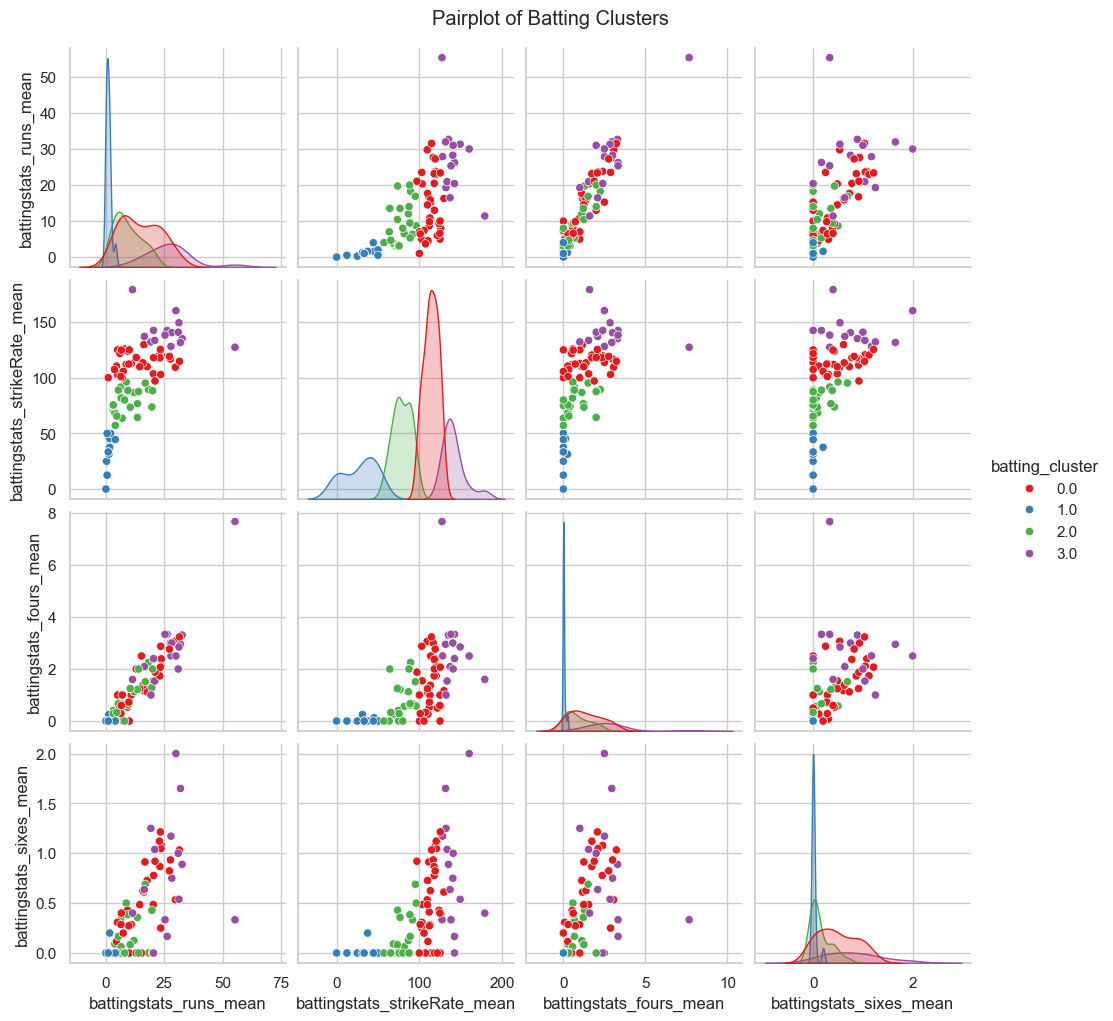

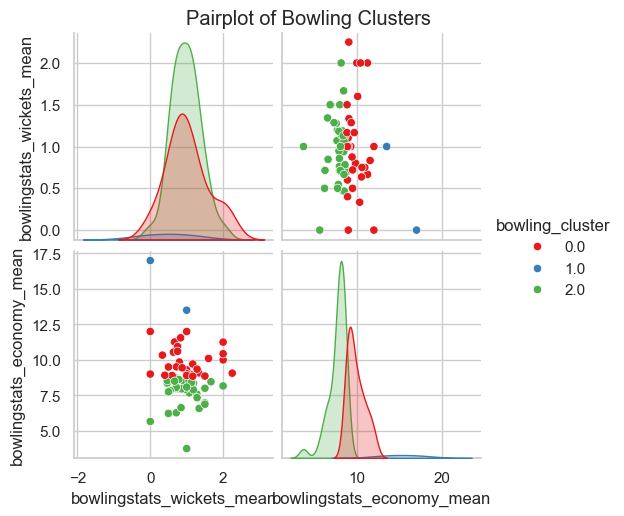

In [234]:
# Pairplot for batting clusters
sns.pairplot(players_info, hue='batting_cluster', vars=batting_columns, palette='Set1')
plt.suptitle('Pairplot of Batting Clusters', y=1.02)
plt.show()

# Pairplot for bowling clusters
sns.pairplot(players_info, hue='bowling_cluster', vars=bowling_columns, palette='Set1')
plt.suptitle('Pairplot of Bowling Clusters', y=1.02)
plt.show()


In [235]:
# Count the number of players in each cluster
batting_cluster_counts = players_info['batting_cluster'].value_counts()
bowling_cluster_counts = players_info['bowling_cluster'].value_counts()

print("Batting Cluster Counts:\n", batting_cluster_counts)
print("Bowling Cluster Counts:\n", bowling_cluster_counts)

# Identify top players in each cluster
top_batters = players_info.sort_values(by='battingstats_runs_mean', ascending=False).groupby('batting_cluster').head(3)
top_bowlers = players_info.sort_values(by='bowlingstats_wickets_mean', ascending=False).groupby('bowling_cluster').head(3)

print("Top Batters in Each Cluster:\n", top_batters[['player_name', 'battingstats_runs_mean', 'batting_cluster']])
print("Top Bowlers in Each Cluster:\n", top_bowlers[['player_name', 'bowlingstats_wickets_mean', 'bowling_cluster']])

Batting Cluster Counts:
 batting_cluster
0.0    36
2.0    23
3.0    15
1.0    15
Name: count, dtype: int64
Bowling Cluster Counts:
 bowling_cluster
2.0    36
0.0    29
1.0     2
Name: count, dtype: int64
Top Batters in Each Cluster:
             player_name  battingstats_runs_mean  batting_cluster
101  Marcus Trescothick               55.333333              3.0
69      Kevin Pietersen               32.666667              3.0
107           Phil Salt               31.950000              3.0
109         Dawid Malan               31.533333              0.0
2              Joe Root               29.766667              0.0
84           Alex Hales               27.653333              0.0
295     Jamie Dalrymple               20.000000              2.0
78       Jonathan Trott               19.714286              2.0
64       Andrew Strauss               18.250000              2.0
515           Pat Brown                4.000000              1.0
172       James Kirtley                2.000000    

In [236]:
top_batters[['player_name', 'battingstats_runs_mean', 'batting_cluster']].head(10)

,player_name,battingstats_runs_mean,batting_cluster
101,Marcus Trescothick,55.333333,3.0
69,Kevin Pietersen,32.666667,3.0
107,Phil Salt,31.950000,3.0
109,Dawid Malan,31.533333,0.0
2,Joe Root,29.766667,0.0
84,Alex Hales,27.653333,0.0
295,Jamie Dalrymple,20.000000,2.0
78,Jonathan Trott,19.714286,2.0
64,Andrew Strauss,18.250000,2.0
515,Pat Brown,4.000000,1.0


In [237]:
top_bowlers[['player_name', 'bowlingstats_wickets_mean', 'bowling_cluster']].head(10)

,player_name,bowlingstats_wickets_mean,bowling_cluster
448,Iain Wardlaw,2.250000,0.0
335,Jon Lewis,2.000000,2.0
81,Monty Panesar,2.000000,0.0
575,Gus Atkinson,2.000000,0.0
179,Mark Wood,1.666667,2.0
383,Harry Gurney,1.500000,2.0
109,Dawid Malan,1.000000,1.0
172,James Kirtley,0.000000,1.0


In [238]:
# Insights on clusters for Batters
for cluster_id in range(kmeans_batting.n_clusters):
    cluster_players = players_info[players_info['batting_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(f"Mean Runs: {cluster_players['battingstats_runs_mean'].mean()}")
    print(f"Mean Strike Rate: {cluster_players['battingstats_strikeRate_mean'].mean()}")
    print(f"Players: {cluster_players['player_name'].tolist()}")
    print()

# Recommendations
# - Cluster 3 consists of high-performing batters with high mean runs and strike rates. Consider these players as core batsmen.
# - Cluster 0 includes players with moderate performance metrics, possibly all-rounders who can contribute to both batting and bowling.
# - Focus on training and development for players in clusters with lower performance metrics to enhance their skills.

Cluster 0:
Mean Runs: 14.911364184112935
Mean Strike Rate: 113.95726958317391
Players: ['Jason Roy', 'Jonny Bairstow', 'Joe Root', 'Eoin Morgan', 'Ben Stokes', 'Moeen Ali', 'Chris Woakes', 'Ravi Bopara', 'Alastair Cook', 'Ian Bell', 'Paul Collingwood', 'Andrew Flintoff', 'Ryan Sidebottom', 'Alex Hales', 'Matt Prior', 'Chris Jordan', 'Tom Curran', 'Stuart Broad', 'Dawid Malan', 'Sam Billings', 'Owais Shah', 'Sam Curran', 'Michael Lumb', 'Mark Wood', 'Tim Bresnan', 'Rob Key', 'Craig Kieswetter', 'Stephen Parry', 'Chris Read', 'James Foster', 'Michael Carberry', 'Tom Banton', 'Chris Schofield', 'Lewis Gregory', 'James Vince', 'Rehan Ahmed']

Cluster 1:
Mean Runs: 0.9816666666666667
Mean Strike Rate: 27.51083333333333
Players: ['James Anderson', 'Monty Panesar', 'Ajmal Shahzad', 'Brydon Carse', 'Reece Topley', 'James Kirtley', 'Tymal Mills', 'Danny Briggs', 'Sajid Mahmood', 'Jon Lewis', 'Matt Parkinson', 'Iain Wardlaw', 'Pat Brown', 'Olly Stone', 'Richard Gleeson']

Cluster 2:
Mean Runs: 9

In [239]:
# Insights example for bowling
for cluster_id in range(kmeans_bowling.n_clusters):
    cluster_players = players_info[players_info['bowling_cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(f"Mean Wickets: {cluster_players['bowlingstats_wickets_mean'].mean()}")
    print(f"Mean Economy Rate: {cluster_players['bowlingstats_economy_mean'].mean()}")
    print(f"Players: {cluster_players['player_name'].tolist()}")
    print()

# Recommendations based on bowling clusters
recommendations = []

for cluster_id in range(kmeans_bowling.n_clusters):
    cluster_players = players_info[players_info['bowling_cluster'] == cluster_id]
    mean_wickets = cluster_players['bowlingstats_wickets_mean'].mean()
    mean_economy = cluster_players['bowlingstats_economy_mean'].mean()
    player_names = cluster_players['player_name'].tolist()
    
    print(f"Cluster {cluster_id}:")
    print(f"Mean Wickets: {mean_wickets}")
    print(f"Mean Economy Rate: {mean_economy}")
    print(f"Players: {player_names}")
    print()

    if mean_wickets > 1.5 and mean_economy < 12:
        recommendations.append(f"Cluster {cluster_id} consists of high-performing bowlers with high mean wickets and low economy rates. Consider these players as key bowlers.")
    elif mean_wickets > 1.5 and mean_economy > 12:
        recommendations.append(f"Cluster {cluster_id} includes players with good wicket-taking ability but higher economy rates. These players can be utilized as aggressive bowlers.")
    else:
        recommendations.append(f"Cluster {cluster_id} includes players with moderate performance metrics. Focus on training and development for these players to enhance their skills.")

# Print all recommendations
for rec in recommendations:
    print(rec)


Cluster 0:
Mean Wickets: 1.0093284895841377
Mean Economy Rate: 9.904614798228591
Players: ['Joe Root', 'Kevin Pietersen', 'Paul Collingwood', 'Monty Panesar', 'Chris Jordan', 'Tom Curran', 'Liam Livingstone', 'Ajmal Shahzad', 'Chris Tremlett', 'Brydon Carse', 'Stuart Meaker', 'Will Jacks', 'Tymal Mills', 'Stephen Parry', 'Luke Wood', 'Danny Briggs', 'Jeremy Snape', 'Joe Denly', 'Sajid Mahmood', 'Matt Parkinson', 'Saqib Mahmood', 'Lewis Gregory', 'Jake Ball', 'Iain Wardlaw', 'Pat Brown', 'Gus Atkinson', 'Olly Stone', 'Rehan Ahmed', 'Richard Gleeson']

Cluster 1:
Mean Wickets: 0.5
Mean Economy Rate: 15.25
Players: ['Dawid Malan', 'James Kirtley']

Cluster 2:
Mean Wickets: 0.9719146001509196
Mean Economy Rate: 7.704425035347381
Players: ['Ben Stokes', 'Moeen Ali', 'Chris Woakes', 'Ravi Bopara', 'Jofra Archer', 'Adil Rashid', 'Steve Harmison', 'Andrew Flintoff', 'Ryan Sidebottom', 'James Anderson', 'David Willey', 'Liam Plunkett', 'Stuart Broad', 'Graeme Swann', 'Michael Yardy', 'Reece Top

The above approach hasn't worked too well for bowlers, so i have used thresholds below to define the top performing bowlers by wickets and economy, and used this to define a new cluster.

In [240]:
# Define thresholds for top-performing bowlers
high_wickets_threshold = 1.5
low_economy_threshold = 12.0

# Initialize an empty DataFrame for top-performing bowlers
top_performing_bowlers = pd.DataFrame()

# Iterate through each cluster to identify top-performing bowlers
for cluster_id in range(kmeans_bowling.n_clusters):
    cluster_players = players_info[players_info['bowling_cluster'] == cluster_id]
    top_bowlers = cluster_players[
        (cluster_players['bowlingstats_wickets_mean'] > high_wickets_threshold) & 
        (cluster_players['bowlingstats_economy_mean'] < low_economy_threshold)
    ]
    top_performing_bowlers = pd.concat([top_performing_bowlers, top_bowlers])

# Assign a new cluster ID to top-performing bowlers
top_performing_bowlers['bowling_cluster'] = 'top_performers'

# Update the players_info DataFrame with the new cluster assignment
players_info.loc[top_performing_bowlers.index, 'bowling_cluster'] = 'top_performers'

# Display insights and recommendations for the new top-performing cluster
print("Top Performing Bowlers Cluster:")
print(f"Mean Wickets: {top_performing_bowlers['bowlingstats_wickets_mean'].mean()}")
print(f"Mean Economy Rate: {top_performing_bowlers['bowlingstats_economy_mean'].mean()}")
print(f"Players: {top_performing_bowlers['player_name'].tolist()}")
print()

# Update recommendations for the new cluster
recommendations.append("The 'top_performers' cluster consists of the highest-performing bowlers with high mean wickets and low economy rates. These players should be considered as primary bowlers for the team.")

# Print all recommendations
for rec in recommendations:
    print(rec)


Top Performing Bowlers Cluster:
Mean Wickets: 1.9309523809523808
Mean Economy Rate: 9.638531746031745
Players: ['Monty Panesar', 'Chris Tremlett', 'Luke Wood', 'Iain Wardlaw', 'Gus Atkinson', 'Mark Wood', 'Jon Lewis']

Cluster 0 includes players with moderate performance metrics. Focus on training and development for these players to enhance their skills.
Cluster 1 includes players with moderate performance metrics. Focus on training and development for these players to enhance their skills.
Cluster 2 includes players with moderate performance metrics. Focus on training and development for these players to enhance their skills.
The 'top_performers' cluster consists of the highest-performing bowlers with high mean wickets and low economy rates. These players should be considered as primary bowlers for the team.


/var/folders/x5/9gjsjc0d2mvdn4wd5rn259zw0000gn/T/ipykernel_28391/741962577.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'top_performers' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  players_info.loc[top_performing_bowlers.index, 'bowling_cluster'] = 'top_performers'


#### Optimisation Problem: MILP

Define the Mixed-Integer Linear Programming (MILP) problem, including decision variables, objective function, and constraints to ensure a balanced team composition.

In [248]:

# Load and prepare data
players_info.fillna(0, inplace=True)

# Identify indices for batters, bowlers, and all-rounders
batters = players_info[players_info['battingstats_runs_mean'] > 0]
bowlers = players_info[players_info['bowlingstats_wickets_mean'] > 0]
all_rounders = players_info[(players_info['battingstats_runs_mean'] > 0) & (players_info['bowlingstats_wickets_mean'] > 0)]

# Create indexes for different types of players
batters_idx = batters.index.tolist()
bowlers_idx = bowlers.index.tolist()
all_rounders_idx = all_rounders.index.tolist()

# Normalize the batting and bowling metrics
players_info['batting_score'] = (
    players_info['battingstats_runs_mean'] / players_info['battingstats_runs_mean'].max() +
    players_info['battingstats_strikeRate_mean'] / players_info['battingstats_strikeRate_mean'].max()
)

players_info['bowling_score'] = (
    players_info['bowlingstats_wickets_mean'] / players_info['bowlingstats_wickets_mean'].max() -
    players_info['bowlingstats_economy_mean'] / players_info['bowlingstats_economy_mean'].max()
)

# Define the MILP problem
prob = LpProblem("OptimalCricketTeam", LpMaximize)

# Define decision variables
player_vars = LpVariable.dicts("Player", players_info.index, cat='Binary')

# Objective: Maximize the sum of normalized batting and bowling performance
# Adjust the weights for batting and bowling metrics
batting_weight = 1.0
bowling_weight = 5.0  # Increase bowling weight

objective = lpSum([
    player_vars[i] * (batting_weight * players_info.at[i, 'batting_score'] +
                      bowling_weight * players_info.at[i, 'bowling_score'])
    for i in players_info.index
])
prob += objective

# Constraints
# Exactly 11 players
prob += lpSum(player_vars[i] for i in players_info.index) == 11

# At least 5 batters
prob += lpSum(player_vars[i] for i in batters_idx) >= 5

# At least 4 bowlers
prob += lpSum(player_vars[i] for i in bowlers_idx) >= 4

# At least 2 all-rounders
prob += lpSum(player_vars[i] for i in all_rounders_idx) >= 2

# Ensure a minimum bowling capability in the team
min_bowling_wickets_mean = 1.0
prob += lpSum(player_vars[i] * players_info.at[i, 'bowlingstats_wickets_mean'] for i in players_info.index) >= min_bowling_wickets_mean

# Solve the problem
prob.solve()

# Extract the optimal team
optimal_team_indices = [i for i in players_info.index if player_vars[i].varValue > 0.5]
optimal_team = players_info.loc[optimal_team_indices]

# Display the final optimal team
print("Optimal Team:")
optimal_team[['player_name', 'battingstats_runs_mean', 'battingstats_strikeRate_mean', 'bowlingstats_wickets_mean', 'bowlingstats_economy_mean']]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x5/9gjsjc0d2mvdn4wd5rn259zw0000gn/T/793431cec2e140a4969f35fe46586395-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/x5/9gjsjc0d2mvdn4wd5rn259zw0000gn/T/793431cec2e140a4969f35fe46586395-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 2621 RHS
At line 2627 BOUNDS
At line 3378 ENDATA
Problem MODEL has 5 rows, 750 columns and 1014 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 20.6099 - 0.00 seconds
Cgl0004I processed model has 5 rows, 95 columns (95 integer (95 of which binary)) and 359 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -20.6099
Cbc0038I Before mini branch and b

,player_name,battingstats_runs_mean,battingstats_strikeRate_mean,bowlingstats_wickets_mean,bowlingstats_economy_mean
79,Ryan Sidebottom,5.000000,125.000000,1.277778,7.595000
81,Monty Panesar,1.000000,50.000000,2.000000,10.000000
95,Graeme Swann,6.500000,81.758125,1.342105,6.576579
101,Marcus Trescothick,55.333333,127.386667,0.000000,0.000000
179,Mark Wood,3.666667,107.403333,1.666667,8.458889
223,Darren Maddy,28.250000,140.460000,1.500000,8.000000
335,Jon Lewis,0.500000,12.500000,2.000000,8.165000
448,Iain Wardlaw,1.000000,33.330000,2.250000,9.062500
460,Phil Mustard,30.000000,160.250000,0.000000,0.000000
575,Gus Atkinson,8.000000,80.000000,2.000000,10.433333


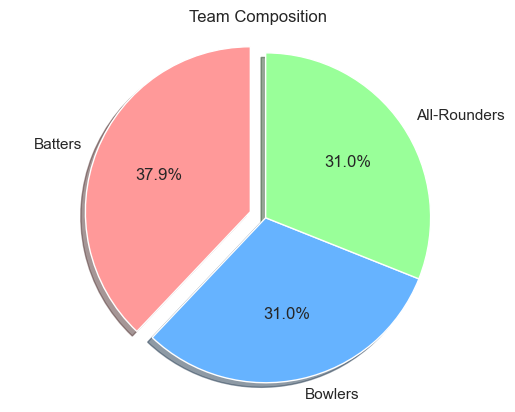

/var/folders/x5/9gjsjc0d2mvdn4wd5rn259zw0000gn/T/ipykernel_28391/3982896032.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='battingstats_runs_mean', data=optimal_team, palette='muted')


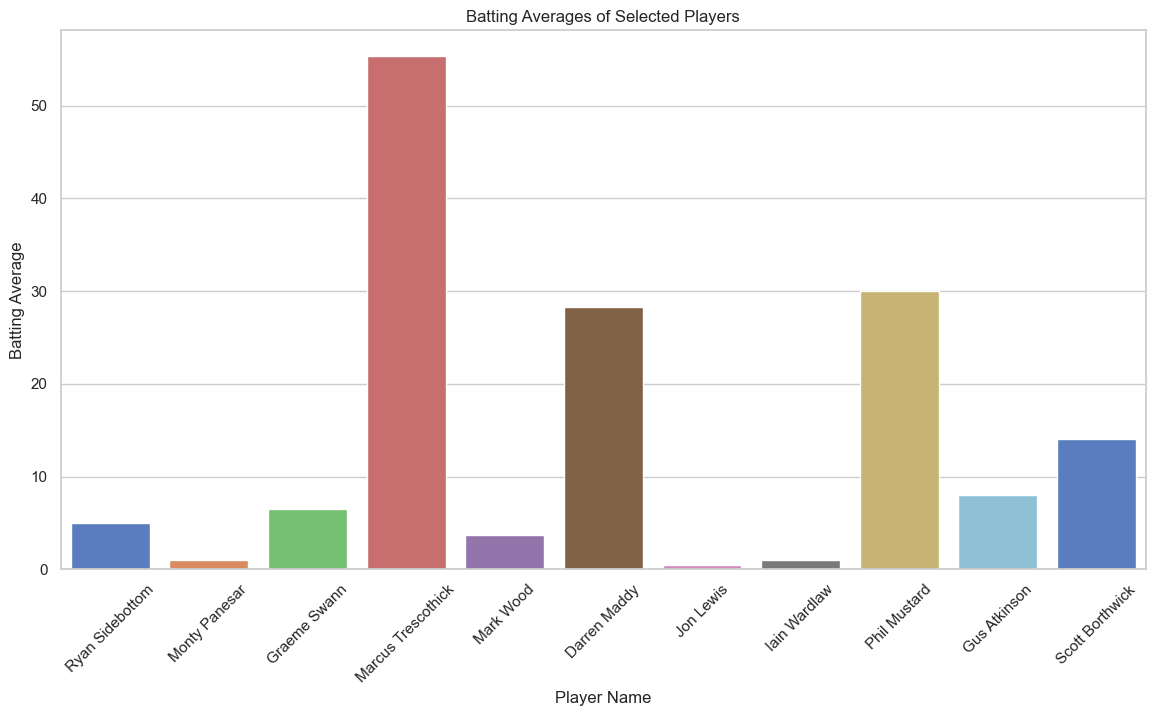

/var/folders/x5/9gjsjc0d2mvdn4wd5rn259zw0000gn/T/ipykernel_28391/3982896032.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='battingstats_strikeRate_mean', data=optimal_team, palette='muted')


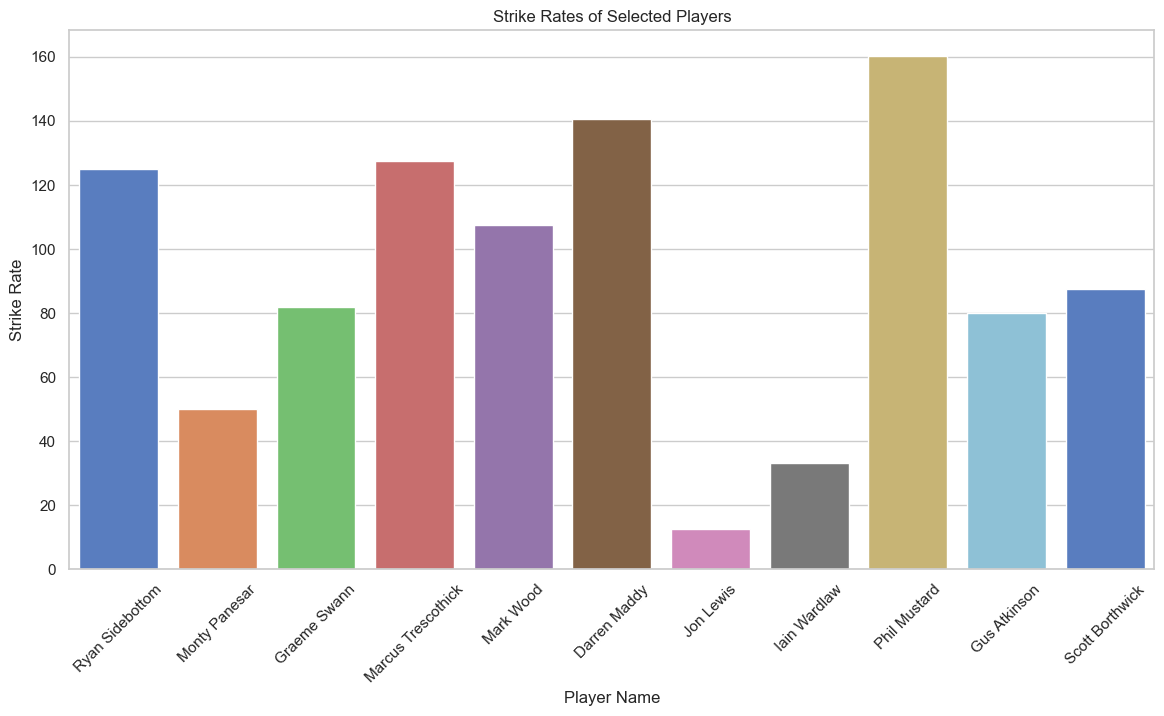

/var/folders/x5/9gjsjc0d2mvdn4wd5rn259zw0000gn/T/ipykernel_28391/3982896032.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='bowlingstats_wickets_mean', data=optimal_team, palette='muted')


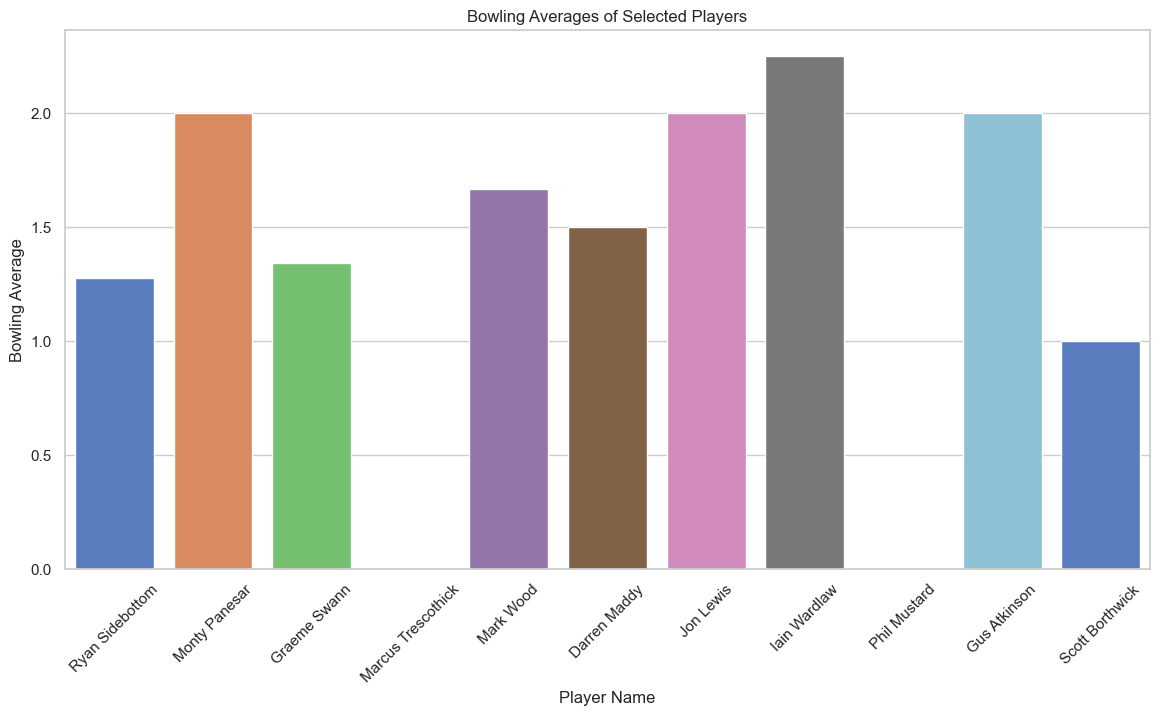

/var/folders/x5/9gjsjc0d2mvdn4wd5rn259zw0000gn/T/ipykernel_28391/3982896032.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='bowlingstats_economy_mean', data=optimal_team, palette='muted')


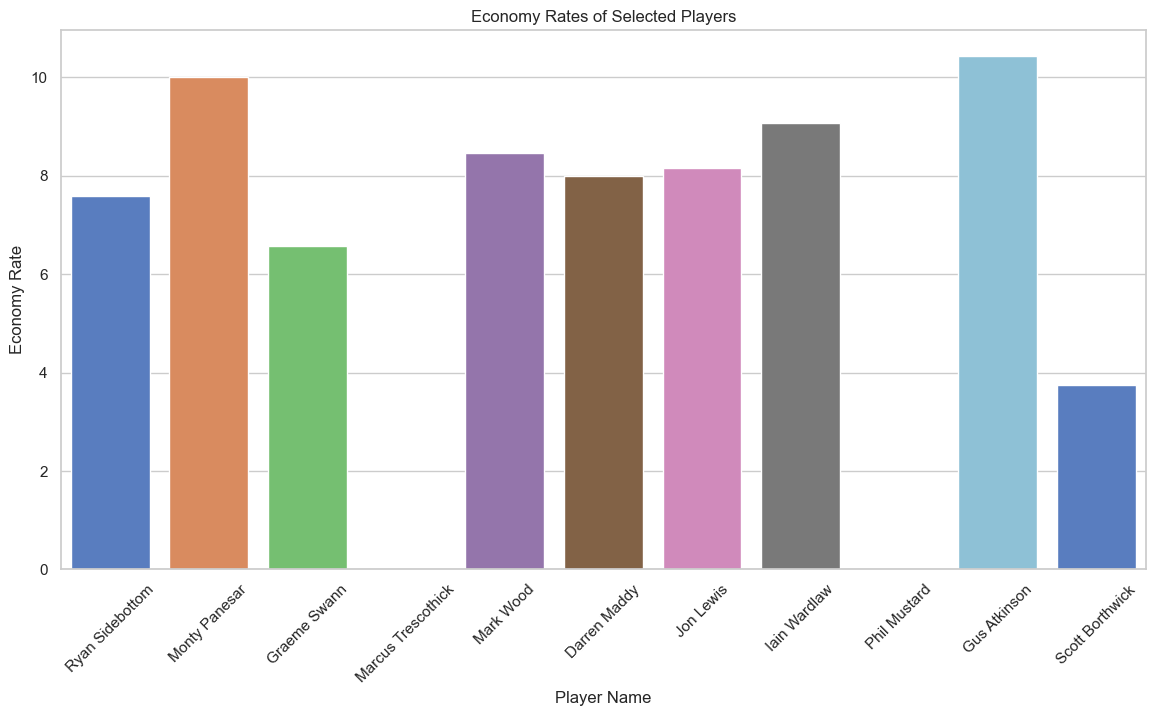

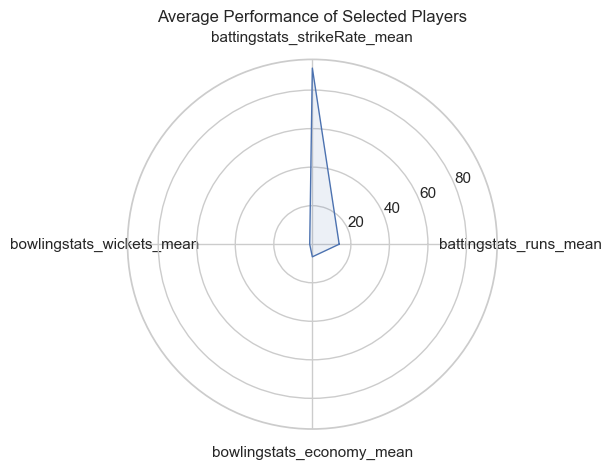

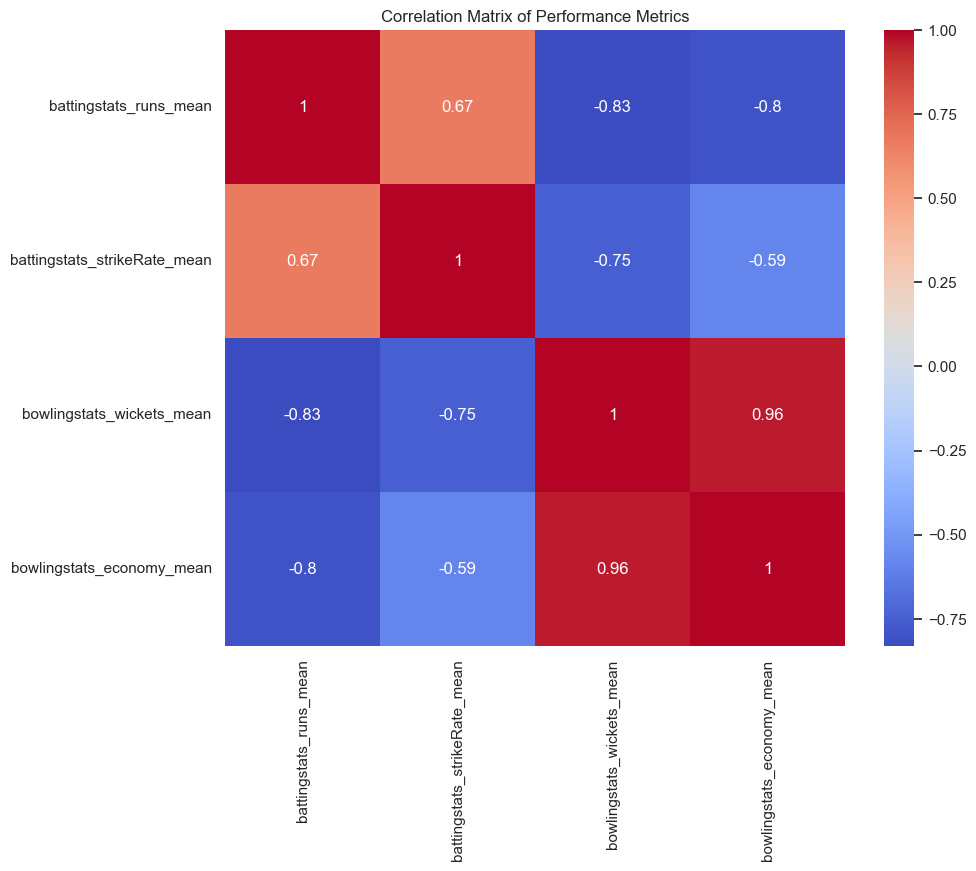

In [252]:
# Visualizations

# Team Composition Pie Chart
num_batters = len(optimal_team[optimal_team.index.isin(batters_idx)])
num_bowlers = len(optimal_team[optimal_team.index.isin(bowlers_idx)])
num_all_rounders = len(optimal_team[optimal_team.index.isin(all_rounders_idx)])

labels = ['Batters', 'Bowlers', 'All-Rounders']
sizes = [num_batters, num_bowlers, num_all_rounders]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Team Composition')
plt.show()

# Batting Performance Bar Chart
plt.figure(figsize=(14, 7))
sns.barplot(x='player_name', y='battingstats_runs_mean', data=optimal_team, palette='muted')
plt.title('Batting Averages of Selected Players')
plt.xticks(rotation=45)
plt.ylabel('Batting Average')
plt.xlabel('Player Name')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='player_name', y='battingstats_strikeRate_mean', data=optimal_team, palette='muted')
plt.title('Strike Rates of Selected Players')
plt.xticks(rotation=45)
plt.ylabel('Strike Rate')
plt.xlabel('Player Name')
plt.show()

# Bowling Performance Bar Chart
plt.figure(figsize=(14, 7))
sns.barplot(x='player_name', y='bowlingstats_wickets_mean', data=optimal_team, palette='muted')
plt.title('Bowling Averages of Selected Players')
plt.xticks(rotation=45)
plt.ylabel('Bowling Average')
plt.xlabel('Player Name')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='player_name', y='bowlingstats_economy_mean', data=optimal_team, palette='muted')
plt.title('Economy Rates of Selected Players')
plt.xticks(rotation=45)
plt.ylabel('Economy Rate')
plt.xlabel('Player Name')
plt.show()

# Radar Chart
def create_radar_chart(data, categories, title):
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)

    ax.plot(angles, data, linewidth=1, linestyle='solid')
    ax.fill(angles, data, 'b', alpha=0.1)

    plt.title(title)
    plt.show()

categories = ['battingstats_runs_mean', 'battingstats_strikeRate_mean', 'bowlingstats_wickets_mean', 'bowlingstats_economy_mean']
player_data = optimal_team[categories].mean().tolist()
player_data += player_data[:1]

create_radar_chart(player_data, categories, 'Average Performance of Selected Players')

# Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = optimal_team[['battingstats_runs_mean', 'battingstats_strikeRate_mean', 'bowlingstats_wickets_mean', 'bowlingstats_economy_mean']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Performance Metrics')
plt.show()
